# Haensel AMS: Predicting Price

**Leng Yang**

**Last Updated: 2/12/25**

## Assignment

Project Source: https://platform.stratascratch.com/data-projects/predicting-price

The target variable is `price`. You have 7 attributes and obviously we want you to build some initial ML model which predicts the prices.

1. Make some initial data analysis, which will hint to some stuctures in the data and how attributes are connected.
2. Fit some ML model(s) and explain briefly your choices.
3. Show with some X-validation the power of your model and comment the results.
4. Present us the results and the steps you have taken and also with some critical thinking and next steps.

## Data Description

The data are provided in the `sample.csv` file.

<BR><BR>

### Data Exploration

In [7]:
#Load in necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import machine learning packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [8]:
#Load in data
df = pd.read_csv('./datasets/sample.csv')

In [9]:
#Dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


In [10]:
#All columns contain numeric values except for 'dow' column
df.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [11]:
#Column loaded in as ojbect - check values for possible errors
df.loc1.value_counts()

loc1
2    1607
0    1486
1    1223
7    1081
3     945
5     846
4     773
8     727
9     690
6     620
S       1
T       1
Name: count, dtype: int64

In [12]:
#Column loaded in as ojbect - check values for possible errors
df.loc2.value_counts().sort_index()

loc2
00      1
01    241
02     63
03    100
04    180
     ... 
97     88
98     25
99    133
S6      1
TS      1
Name: count, Length: 107, dtype: int64

In [13]:
#Check column to ensure values align with days of the week
df.dow.value_counts()

dow
Wed    2233
Tue    1997
Fri    1931
Mon    1918
Thu    1908
Sat      10
Sun       3
Name: count, dtype: int64

In [14]:
#Review rows containing invalid values in loc1 and loc2
df[(df.loc1.str.contains('[a-z]', case=False)) | (df.loc2.str.contains('[a-z]', case=False))]

,loc1,loc2,para1,dow,para2,para3,para4,price
2887,0,0B,2,Mon,801,1091.0,9.0,1350.0
3026,S,S6,3,Fri,1289,24000.0,13.6,850.0
4850,0,0T,2,Mon,1473,4000.0,2.0,1890.0
5510,T,TS,3,Fri,1472,1600.0,2.0,440.0
5647,0,0L,2,Wed,1127,10000.0,13.6,750.0
7751,0,0C,3,Fri,623,1500.0,6.0,400.0
8466,0,0N,3,Fri,1298,3500.0,2.1,1500.0


In [15]:
#Drop rows containing invalid values
df.drop(df[(df.loc1.str.contains('[a-z]', case=False)) | (df.loc2.str.contains('[a-z]', case=False))].index, inplace=True)

In [16]:
#Convert loc1 and loc2 to numeric
df.loc1 = df.loc1.astype('int')
df.loc2 = df.loc2.astype('int')

In [17]:
#Descriptive statistics
df.describe()

,loc1,loc2,para1,para2,para3,para4,price
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,3.793355,42.468028,1.379966,446.888522,9550.105894,8.460614,433.318379
std,2.892286,29.350079,3.501891,220.141080,8022.655794,4.613156,276.743453
min,0.000000,0.000000,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,16.000000,1.000000,301.000000,2900.000000,4.000000,250.000000
50%,3.000000,37.000000,1.000000,434.000000,6448.000000,7.200000,370.000000
75%,6.000000,69.000000,1.000000,582.000000,15000.000000,13.600000,550.000000
max,9.000000,99.000000,337.000000,2554.000000,34782.000000,27.200000,5700.000000


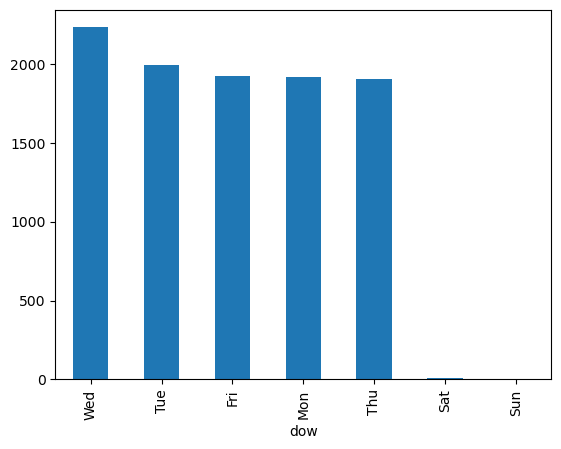

In [18]:
#Days of the week value counts
df.dow.value_counts().plot(kind='bar');

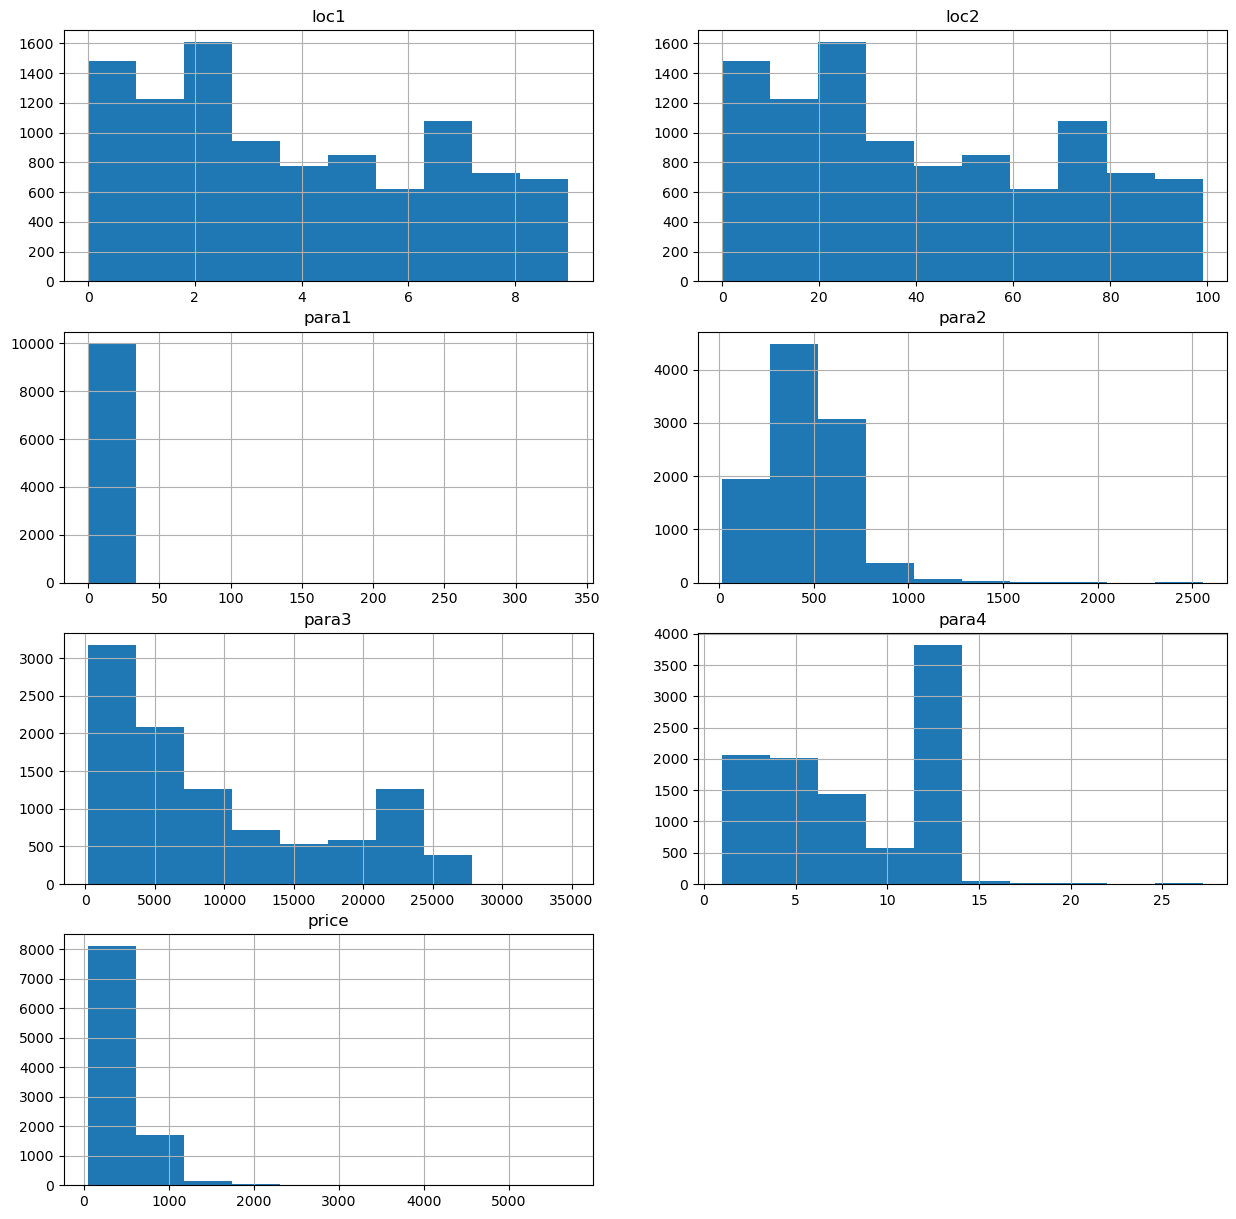

In [19]:
#Histograms
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=[15, 15])
num_par = df.select_dtypes(include='number').columns
x = 0
for i in range(4):
    for j in range(2):
        df[num_par[x]].hist(ax=axes[i,j])
        axes[i,j].set_title(num_par[x])
        x += 1
        if x >= len(num_par):
            break
fig.delaxes(axes[3,1])

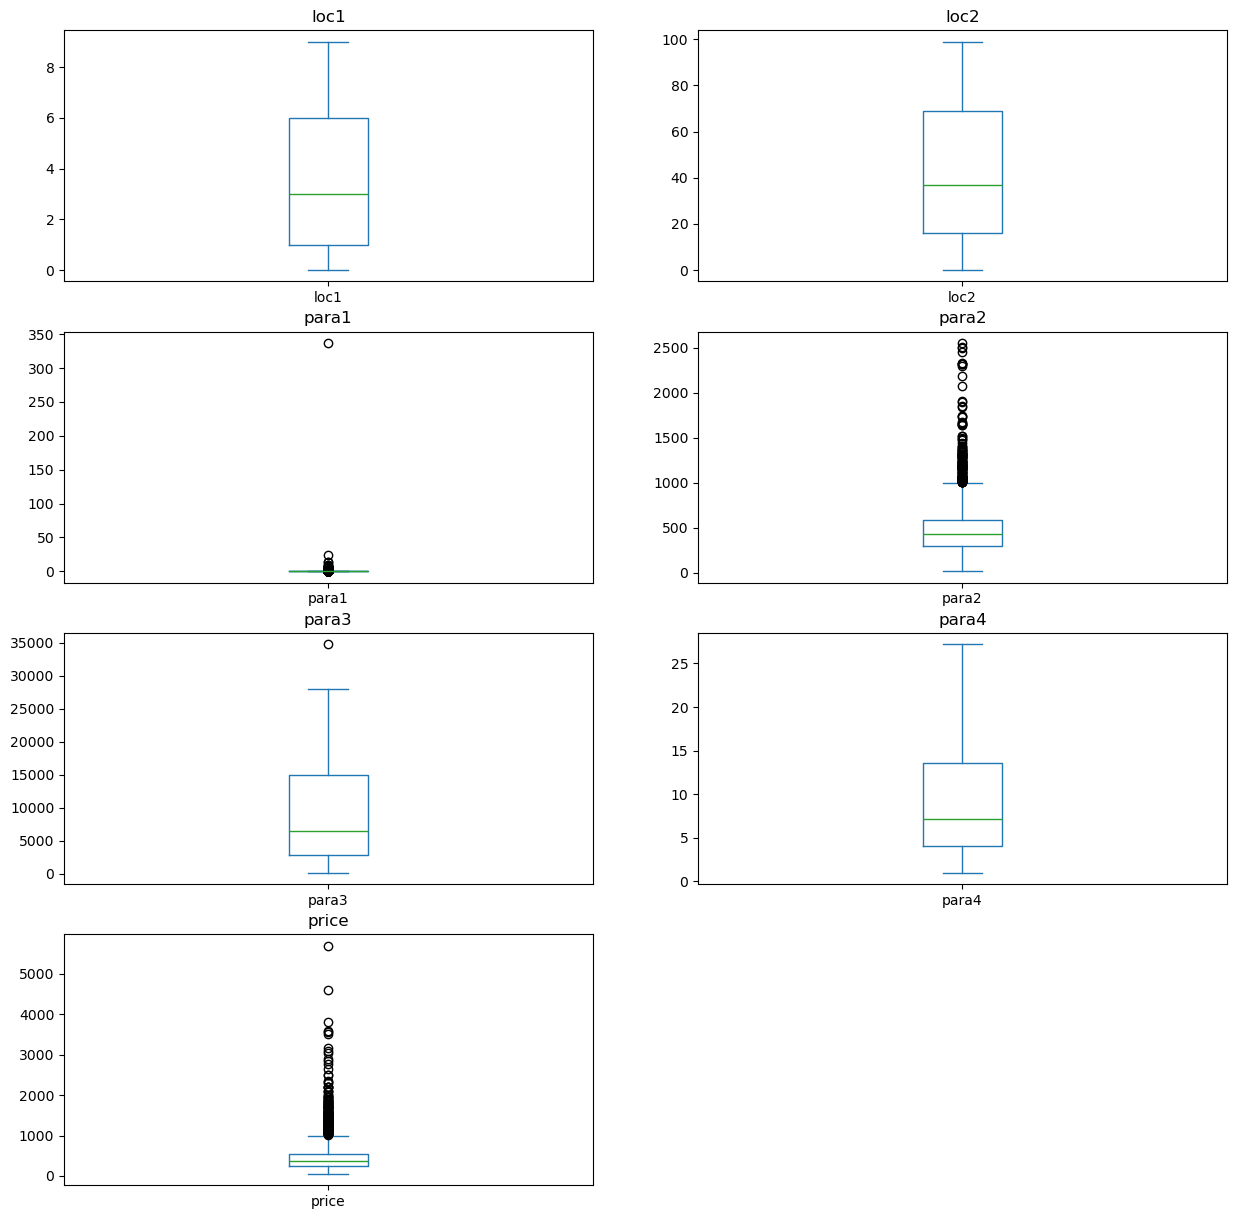

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=[15, 15])
num_par = df.select_dtypes(include='number').columns
x = 0
for i in range(4):
    for j in range(2):
        df[num_par[x]].plot.box(ax=axes[i,j])
        axes[i,j].set_title(num_par[x])
        x += 1
        if x >= len(num_par):
            break
fig.delaxes(axes[3,1])

### Data Cleaning

In [22]:
#Check values against boxplots to determine clear outliers and cutoff points
df.para1.value_counts().sort_index()

para1
0       836
1      7052
2       265
3      1609
4       164
5        51
6         6
7         3
8         1
9         2
13        2
24        1
337       1
Name: count, dtype: int64

In [23]:
df.para3.value_counts().sort_index()

para3
200.0      8
202.0      1
203.0      1
209.0      1
210.0      2
          ..
26099.0    1
26201.0    1
26225.0    1
28000.0    1
34782.0    1
Name: count, Length: 4359, dtype: int64

In [24]:
#Drop outlier values

#para2 upper-bound using IQR
upper_bound = 1.5 * (df.para2.quantile(0.75) - df.para2.quantile(0.25)) + df.para2.quantile(0.75)

df.drop(df[(df.para1 > 10) | (df.para2 > upper_bound) | (df.para3 > 34000)].index, inplace=True)

In [25]:
#Correlation of numeric features
df.select_dtypes(include='number').corr()

,loc1,loc2,para1,para2,para3,para4,price
loc1,1.000000,0.995070,0.027582,0.096890,-0.123890,-0.125879,-0.032039
loc2,0.995070,1.000000,0.030597,0.094918,-0.117768,-0.122915,-0.032170
para1,0.027582,0.030597,1.000000,0.200850,-0.033229,-0.044341,0.113636
para2,0.096890,0.094918,0.200850,1.000000,-0.016252,-0.001390,0.429542
para3,-0.123890,-0.117768,-0.033229,-0.016252,1.000000,0.691696,0.398840
para4,-0.125879,-0.122915,-0.044341,-0.001390,0.691696,1.000000,0.581740
price,-0.032039,-0.032170,0.113636,0.429542,0.398840,0.581740,1.000000


### Data Processing

In [27]:
#Convert 'dow' to numeric values
dow_map = {'Sun':0, 'Mon':1, 'Tue':2, 'Wed':3, 'Thu':4, 'Fri':5, 'Sat':6}

df.dow = df.dow.map(dow_map)

In [28]:
df.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,1,1,1,662,3000.0,3.8,73.49
1,9,99,1,4,340,2760.0,9.2,300.00
2,0,4,0,1,16,2700.0,3.0,130.00
3,4,40,1,1,17,12320.0,6.4,365.00
4,5,50,1,4,610,2117.0,10.8,357.50


### Model Training

In [30]:
#Select for X and y matrices
X = df.drop('price', axis=1)
y = df.price

#Split Data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

* **Multiple Linear Regression**

In [32]:
#Make pipeline
pipe = make_pipeline(StandardScaler(), RFECV(LinearRegression(), scoring='neg_mean_squared_error'), LinearRegression())

#Fit model using pipeline and calculate MSE score for testing data
pipe.fit(X_train, y_train)
print('Model Selected Parameters:', X_train.columns[pipe['rfecv'].support_])
print('Model R-squared:', r2_score(y_train, pipe.predict(X_train)))
print('Training Error:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Testing Error:', mean_squared_error(y_test, pipe.predict(X_test)))

Model Selected Parameters: Index(['loc1', 'loc2', 'para1', 'dow', 'para2', 'para4'], dtype='object')
Model R-squared: 0.5233277002774862
Training Error: 26310.097493126515
Testing Error: 21313.96074882139


* **Ridge Regression**

In [34]:
pipe = make_pipeline(StandardScaler(), RFECV(Ridge(), scoring='neg_mean_squared_error'), Ridge(random_state=1))
pipe.fit(X_train, y_train)
print('Model Selected Parameters:', X_train.columns[pipe['rfecv'].support_])
print('Model R-squared:', r2_score(y_train, pipe.predict(X_train)))
print('Training Error:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Testing Error:', mean_squared_error(y_test, pipe.predict(X_test)))

Model Selected Parameters: Index(['loc1', 'loc2', 'para1', 'dow', 'para2', 'para4'], dtype='object')
Model R-squared: 0.5233276709182468
Training Error: 26310.0991136202
Testing Error: 21314.083731787316


* **Decision Tree**

In [36]:
pipe = make_pipeline(StandardScaler(), RFECV(DecisionTreeRegressor(random_state=1), scoring='neg_mean_squared_error'), DecisionTreeRegressor(random_state=1))
pipe.fit(X_train, y_train)
print('Model Selected Parameters:', X_train.columns[pipe['rfecv'].support_])
print('Model R-squared:', r2_score(y_train, pipe.predict(X_train)))
print('Training Error:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Testing Error:', mean_squared_error(y_test, pipe.predict(X_test)))

Model Selected Parameters: Index(['para2', 'para4'], dtype='object')
Model R-squared: 0.8782576262775379
Training Error: 6719.613712706241
Testing Error: 30059.943709988558


* **Random Forest**

In [38]:
pipe = make_pipeline(StandardScaler(), RFECV(RandomForestRegressor(random_state=1), scoring='neg_mean_squared_error'), RandomForestRegressor(random_state=1))
pipe.fit(X_train, y_train)
print('Model Selected Parameters:', X_train.columns[pipe['rfecv'].support_])
print('Model R-squared:', r2_score(y_train, pipe.predict(X_train)))
print('Training Error:', mean_squared_error(y_train, pipe.predict(X_train)))
print('Testing Error:', mean_squared_error(y_test, pipe.predict(X_test)))

Model Selected Parameters: Index(['loc2', 'para1', 'dow', 'para2', 'para3', 'para4'], dtype='object')
Model R-squared: 0.949075955897229
Training Error: 2810.7707661387703
Testing Error: 16096.952253286121


* **Random Forest Hyperparameter Tuning**

In [43]:
#Hyperparameter Tuning using all features from previous model selection testing
grid = {'randomforestregressor__max_depth': [None, 1, 2 , 5, 10],
        'randomforestregressor__max_features': [None, 'sqrt'],
        'randomforestregressor__min_samples_leaf': [1, 2, 5, 10]}

pipe = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1))
rfr = GridSearchCV(pipe, param_grid=grid, scoring='neg_mean_squared_error')

rfr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=1))]),
             param_grid={'randomforestregressor__max_depth': [None, 1, 2, 5,
                                                              10],
                         'randomforestregressor__max_features': [None, 'sqrt'],
                         'randomforestregressor__min_samples_leaf': [1, 2, 5,
                                                                     10]},
             scoring='neg_mean_squared_error')

In [47]:
#List out the best parameters
rfr.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__min_samples_leaf': 1}

In [49]:
#Print scores
print('Model R-squared:', r2_score(y_train, rfr.predict(X_train)))
print('Training Error:', mean_squared_error(y_train, rfr.predict(X_train)))
print('Testing Error:', mean_squared_error(y_test, rfr.predict(X_test)))

Model R-squared: 0.9509899535473012
Training Error: 2705.126983598168
Testing Error: 15556.097639825803


<BR>

### Limitations and Results

**Limitations**
* A lack of a data dictionary makes it difficult to understand the underlying data.

**Results**
* Multiple models were trained to select for the best model, which included multiple linear regression, ridge regression, decision tree regression, and random forest regression, with hyperparameter tuning.
* During training, recursive feature elimination with cross-validation was used to select for the best features for each model.
* Of all models tested, random forest regression yielded the best model with the righest R-squared and lowest training and testing error, although some form of overfitting does exist.